In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

In [3]:
f = h5py.File('/Users/ahyeon/Desktop/activ misc/predict_scores2.h5', 'r')

In [4]:
predictions = f['score'][:]
norm_predictions = f['norm_score'][:]
labels = f['clusters'][:]
umap_dims = f['umap_dimensions'][:]
cluster_sizes = f['cluster_sizes'][:]
cluster_sizes

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [33]:
len(cluster_sizes)

49

In [46]:
predictions.shape
labels.shape

(50, 49, 247)

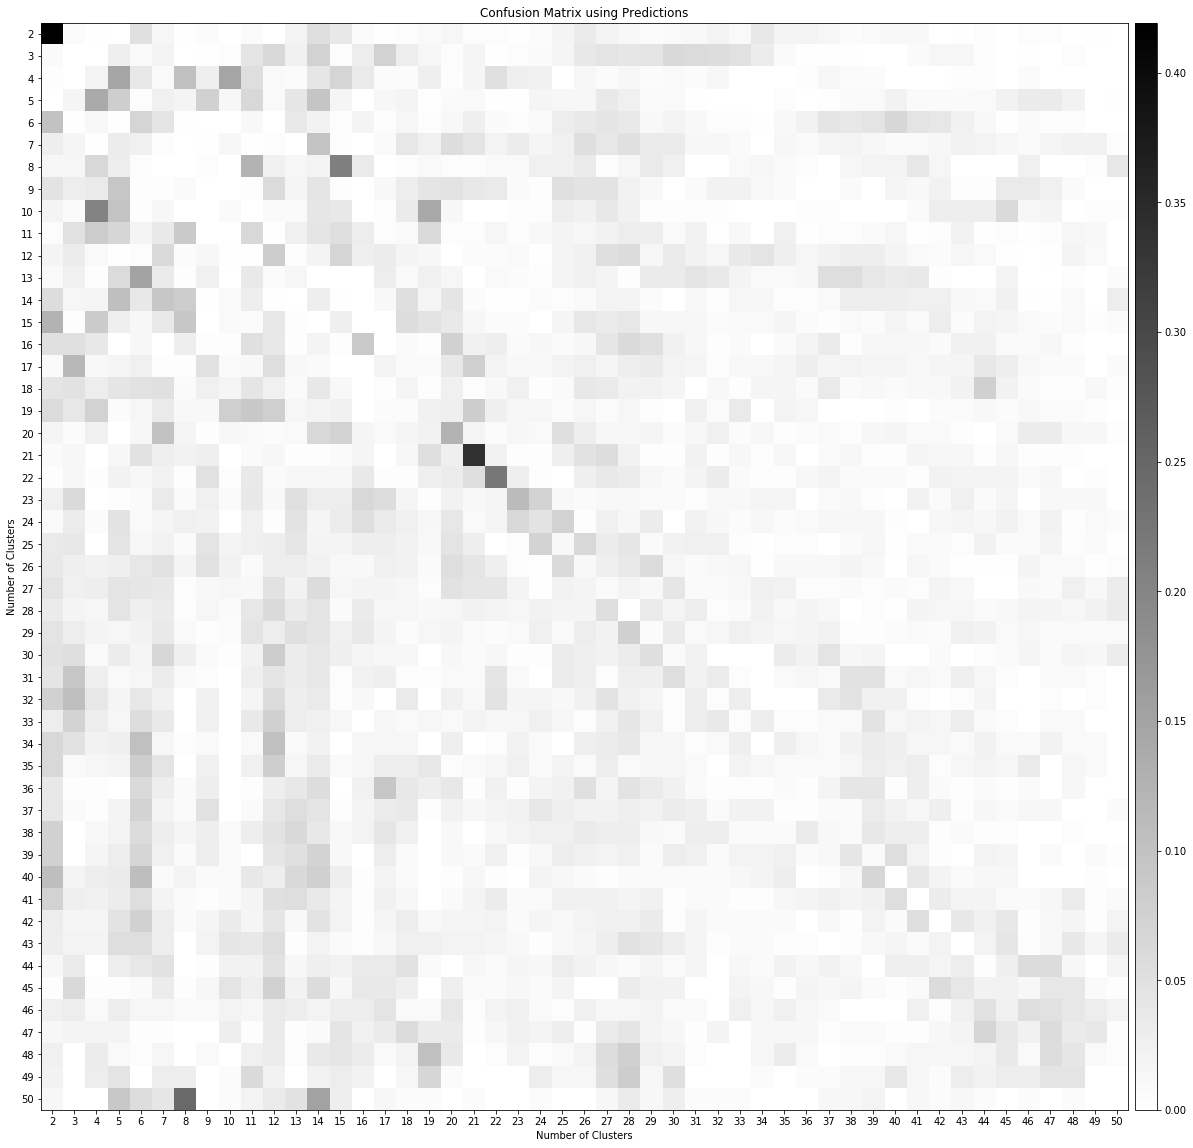

In [75]:
# Confusion Matrix
csize = 49
conf = np.zeros((predictions.shape[0],csize,csize))

for i in range(predictions.shape[0]):
    labs = list(map(int,labels[i,csize-2,:]))
    preds = list(map(int,predictions[i,csize-2,:]))
    for l,p in zip(labs, preds):
        conf[i,l,p] += 1

new_conf = conf.mean(axis=0)
new_conf = np.matrix((new_conf))
denom = np.array(new_conf.sum(axis=1))

new_denom = np.repeat(denom, csize, axis=1)
this = new_conf/new_denom

heatmap(this, cluster_sizes, cluster_sizes, xlab='Number of Clusters', ylab = 'Number of Clusters', title='Confusion Matrix using Predictions')
plt.savefig('/Users/ahyeon/Desktop/activ misc/confusion_matrix.pdf')



In [22]:
# Return true positive, true negative, false positive, false negative given a matrix, cluster number, and specified 
# size of matrix 

def confusion_matrix_values(conf_mat, cluster_num, size):
    this = np.matrix(conf_mat[:size,:size])
    for i in range(size):
        if (i==cluster_num):
            tp = this[i,i]
            tn = this.sum() - this[i,:].sum() - this[:,i].sum()
            fp = this[:,i].sum() - this[i,i]
            fn = this[i,:].sum() - this[i,i]
    return tp, tn, fp, fn

In [80]:
# specificity
def true_neg_rate(tn, fp):
    return tn/(tn+fp)

# sensitivity/recall
def true_pos_rate(tp, fn):
    return tp/(tp+fn)

def false_neg_rate(fn, tp):
    return fn/(fn+tp)
    
def false_pos_rate(fp, tn):
    return fp/(fp+tn)
    
def precision(tp, fp):
    return tp/(tp+fp)

def fscore(tp, fp, fn):
    return (2*tp)/(2*tp + fp + fn)

def accuracy(tp, tn, fp, fn):
    return (tp+tn)/(tp+tn+fp+fn)

In [21]:
tp, tn, fp, fn = confusion_matrix_values(this, 20, 50)
f_score = fscore(tp, fp, fn)
recall = true_pos_rate(tp, fn)
preci = precision(tp, fp)

f_score, recall, preci

(0.26605106245920201, 0.2788461538461538, 0.2543786817057862)

(50, 49, 247)

(0.0, 1.0)

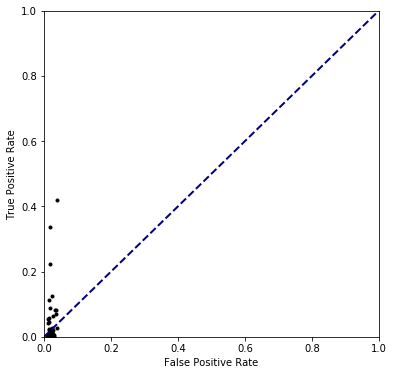

In [79]:
# ROC Curve
fprs = []
tprs = []
f_scores = []
size=49
for i in range(size):
    tp, tn, fp, fn = confusion_matrix_values(this, i, size)
    fpr = false_pos_rate(fp, tn)
    tpr = true_pos_rate(tp, fn)
    preci = precision(tp, fp)
    f_score = fscore(tp, fp, fn)
    f_scores.append(f_score)
    fprs.append(fpr)
    tprs.append(tpr)
    
plt.figure(figsize=(6,6))
plt.plot(fprs, tprs, '.', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

In [29]:
len(f_scores)
len(cluster_sizes)

49

Text(0.5,1,'F Score of Cluster Sizes')

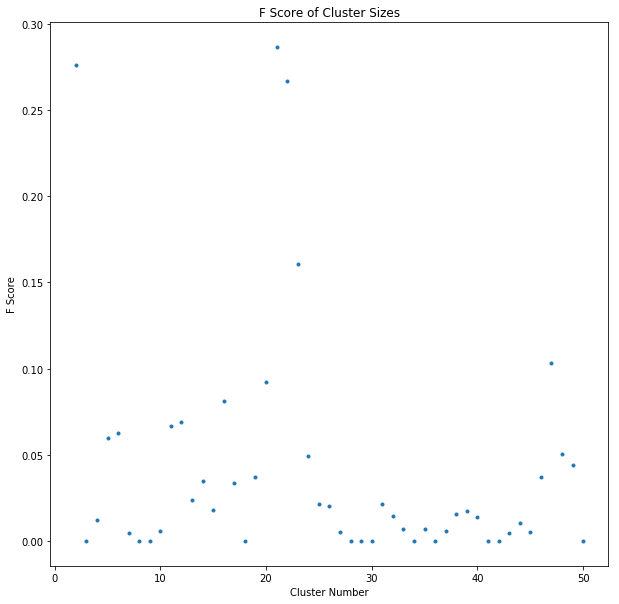

In [32]:
plt.plot(cluster_sizes,f_scores,'.')
plt.xlabel('Cluster Number')
plt.ylabel('F Score')
plt.title('F Score of Cluster Sizes')

In [96]:
pred_bin = label_binarize(predictions[0][0], classes=cluster_sizes)

In [97]:
pred_bin.shape

(247, 49)

In [ ]:
# ROC Curve

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

(150, 3)
(150, 3)


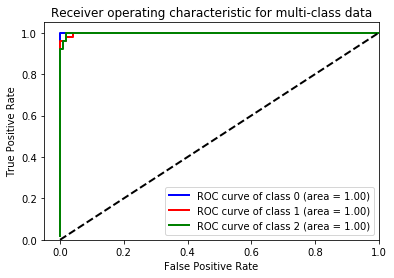

In [100]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

iris = datasets.load_iris()
X = iris.data
y = iris.target
# Binarize the output
y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]
print(y_bin.shape)
clf = OneVsRestClassifier(QDA())
y_score = cross_val_predict(clf, X, y, cv=10 ,method='predict_proba')
print(y_score.shape)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()